In [3]:
from utils.config import COMMON_CONFIG
from utils.data import train_test_split

!pip install scikit-learn -q

!pip install matplotlib -q

import warnings
warnings.filterwarnings("ignore")

!pip install pandas -q
import pandas as pd
# Хак чтобы работало на Anaconda под MacOs 10.15.7 Catalina
pd.DataFrame.iteritems = pd.DataFrame.items

ticker = COMMON_CONFIG.SYMBOL.replace('/', '')
X_csv = COMMON_CONFIG.DATA_PATH + COMMON_CONFIG.SYMBOL.replace('/', '_') + '_' + COMMON_CONFIG.TIMEFRAME + '_X_features.csv'

In [4]:
#!pip install git+https://github.com/kernc/backtesting.py.git -q
!pip install backtesting -q

from backtesting import Strategy
from utils.backtest import run_backtest

In [5]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import numpy as np

def seed_everything(seed: int = COMMON_CONFIG.SEED) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    print(f"Using {seed} seed")

# Зафиксируем SEED
seed_everything(COMMON_CONFIG.SEED)

Using 777 seed


In [6]:
from utils.files import read_data_from_file

df = read_data_from_file(COMMON_CONFIG.DATA_PATH, COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME)
df

,open,high,low,close,volume
date,,,,,
2020-01-01 00:00:00,129.16,129.19,128.68,128.87,7769.17336
2020-01-01 01:00:00,128.87,130.65,128.78,130.64,11344.65516
2020-01-01 02:00:00,130.63,130.98,130.35,130.85,7603.35623
2020-01-01 03:00:00,130.85,130.89,129.94,130.20,4968.55433
2020-01-01 04:00:00,130.21,130.74,130.15,130.20,3397.90747
...,...,...,...,...,...
2025-01-26 16:00:00,3315.31,3320.00,3307.96,3315.82,6878.43040
2025-01-26 17:00:00,3315.83,3344.88,3315.36,3338.04,9465.04360
2025-01-26 18:00:00,3338.03,3342.92,3334.02,3337.16,8731.04880


In [7]:
!pip install tsfresh -q

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute

In [8]:
df_melted = pd.DataFrame()
df_melted["timestamp"] = df.index
df_melted["close"] = df['close'].values
df_melted['symbol'] = ticker
df_melted

,timestamp,close,symbol
0,2020-01-01 00:00:00,128.87,ETHUSDT
1,2020-01-01 01:00:00,130.64,ETHUSDT
2,2020-01-01 02:00:00,130.85,ETHUSDT
3,2020-01-01 03:00:00,130.20,ETHUSDT
4,2020-01-01 04:00:00,130.20,ETHUSDT
...,...,...,...
44430,2025-01-26 16:00:00,3315.82,ETHUSDT
44431,2025-01-26 17:00:00,3338.04,ETHUSDT
44432,2025-01-26 18:00:00,3337.16,ETHUSDT
44433,2025-01-26 19:00:00,3338.74,ETHUSDT


In [7]:
df_rolled = roll_time_series(df_melted, column_id="symbol", column_sort="timestamp",
                             min_timeshift=COMMON_CONFIG.TS_FRESH_MIN_WINDOW_SIZE,
                             max_timeshift=COMMON_CONFIG.TS_FRESH_MAX_WINDOW_SIZE)
df_rolled

Rolling: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


,timestamp,close,symbol,id
0,2023-01-01 00:00:00,1194.09,ETHUSDT,"(ETHUSDT, 2023-01-01 05:00:00)"
1,2023-01-01 01:00:00,1196.02,ETHUSDT,"(ETHUSDT, 2023-01-01 05:00:00)"
2,2023-01-01 02:00:00,1195.40,ETHUSDT,"(ETHUSDT, 2023-01-01 05:00:00)"
3,2023-01-01 03:00:00,1194.04,ETHUSDT,"(ETHUSDT, 2023-01-01 05:00:00)"
4,2023-01-01 04:00:00,1192.92,ETHUSDT,"(ETHUSDT, 2023-01-01 05:00:00)"
...,...,...,...,...
1108533,2025-01-28 08:00:00,3198.40,ETHUSDT,"(ETHUSDT, 2025-01-28 12:00:00)"
1108534,2025-01-28 09:00:00,3196.92,ETHUSDT,"(ETHUSDT, 2025-01-28 12:00:00)"
1108535,2025-01-28 10:00:00,3194.38,ETHUSDT,"(ETHUSDT, 2025-01-28 12:00:00)"
1108536,2025-01-28 11:00:00,3186.74,ETHUSDT,"(ETHUSDT, 2025-01-28 12:00:00)"


In [8]:
# X = extract_features(df_rolled.drop("symbol", axis=1), 
#                      column_id="id", column_sort="timestamp", column_value="close", 
#                      impute_function=impute, show_warnings=False)
# X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
# X.index.name = "last_timestamp"
# X

Feature Extraction: 100%|██████████| 40/40 [02:30<00:00,  3.75s/it]


,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__query_similarity_count__query_None__threshold_0.0,close__mean_n_absolute_max__number_of_maxima_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 05:00:00,0.0,0.0,0.0,0.0,7167.01,8.561011e+06,1.330000,0.090000,-0.038750,1194.315,...,1.039721,1.039721,1.386294,1.039721,1.098612,0.693147,-0.000000,3.982128,0.0,2372.555714
2023-01-01 06:00:00,0.0,0.0,0.0,0.0,8361.82,9.988582e+06,1.153333,0.120000,-0.166000,1194.540,...,1.039721,1.039721,1.386294,1.332179,1.386294,1.098612,0.693147,-0.000000,0.0,2372.555714
2023-01-01 07:00:00,0.0,0.0,0.0,0.0,9556.88,1.141675e+07,1.024286,0.138571,-0.140000,1194.675,...,1.054920,1.332179,1.609438,1.329661,1.609438,1.386294,1.098612,0.693147,0.0,1194.851429
2023-01-01 08:00:00,0.0,0.0,0.0,0.0,10751.16,1.284306e+07,0.993750,0.023750,-0.193571,1194.540,...,1.332179,1.332179,1.609438,1.549826,1.791759,1.609438,1.386294,1.098612,0.0,1194.885714
2023-01-01 09:00:00,0.0,0.0,0.0,0.0,11947.64,1.427462e+07,1.127778,0.265556,0.016875,1194.675,...,1.329661,1.329661,1.791759,1.559581,1.945910,1.791759,1.609438,1.386294,0.0,1195.227143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28 08:00:00,1.0,0.0,0.0,0.0,196616.25,6.343476e+08,15.372833,-2.310500,-0.001864,3212.370,...,0.283936,0.283936,0.822522,1.648589,2.626584,3.351195,3.733120,3.931717,0.0,3341.730000
2025-01-28 09:00:00,1.0,0.0,0.0,0.0,196476.14,6.334321e+08,15.357500,-2.375167,0.029915,3203.150,...,0.283936,0.283936,0.867241,1.645750,2.618756,3.317694,3.733120,3.931717,0.0,3341.730000
2025-01-28 10:00:00,1.0,0.0,0.0,0.0,196331.09,6.324844e+08,15.316333,-2.334000,0.111102,3198.400,...,0.283936,0.424254,0.928839,1.645750,2.627778,3.342015,3.757876,3.931717,0.0,3341.531429


In [9]:
# X.to_csv(X_csv)

In [9]:
X = pd.read_csv(X_csv)
X["last_timestamp"] = pd.to_datetime(X["last_timestamp"])
X.set_index('last_timestamp', inplace=True)
X

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__query_similarity_count__query_None__threshold_0.0,close__mean_n_absolute_max__number_of_maxima_7
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 05:00:00,0.0,0.0,0.0,1.0,781.06,1.016782e+05,0.546000,0.286000,-0.208750,130.25,...,1.039721,1.386294,1.386294,1.039721,1.098612,0.693147,-0.000000,3.982128,0.0,1916.527143
2020-01-01 06:00:00,0.0,0.0,0.0,1.0,911.50,1.186928e+05,0.478333,0.261667,-0.163000,130.30,...,1.386294,1.386294,1.386294,0.950271,1.386294,1.098612,0.693147,-0.000000,0.0,1916.527143
2020-01-01 07:00:00,0.0,0.0,0.0,1.0,1041.74,1.356552e+05,0.438571,0.195714,-0.164167,130.27,...,0.950271,0.950271,1.609438,1.011404,1.332179,1.386294,1.098612,0.693147,0.0,130.410000
2020-01-01 08:00:00,0.0,0.0,0.0,1.0,1172.10,1.526490e+05,0.398750,0.186250,-0.117857,130.30,...,1.332179,1.609438,1.609438,1.078992,1.560710,1.609438,1.386294,1.098612,0.0,130.432857
2020-01-01 09:00:00,0.0,0.0,0.0,1.0,1302.27,1.695932e+05,0.375556,0.144444,-0.122500,130.27,...,1.011404,1.329661,1.791759,1.082196,1.747868,1.791759,1.609438,1.386294,0.0,130.432857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 16:00:00,1.0,0.0,0.0,0.0,203536.41,6.792157e+08,10.431000,-0.293000,-0.644492,3331.18,...,0.379535,0.611952,1.344137,1.675807,2.640149,3.363593,3.793211,3.956922,0.0,3404.132857
2025-01-26 17:00:00,1.0,0.0,0.0,0.0,203541.05,6.792466e+08,9.525333,-1.198667,0.387966,3331.18,...,0.379535,0.611952,1.344137,1.661064,2.621104,3.324131,3.768455,3.956922,0.0,3404.132857
2025-01-26 18:00:00,1.0,0.0,0.0,0.0,203468.25,6.787554e+08,9.147333,-0.820667,0.040000,3331.18,...,0.379535,0.611952,1.353234,1.677865,2.598396,3.299810,3.768455,3.956922,0.0,3402.410000


In [10]:
y = df_melted.set_index("timestamp").sort_index().close.shift(-1)
y.tail(3)

timestamp
2025-01-26 18:00:00    3338.74
2025-01-26 19:00:00    3338.08
2025-01-26 20:00:00        NaN
Name: close, dtype: float64

In [11]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [12]:
X_train, X_test = train_test_split(X)
y_train, y_test = train_test_split(y)

Train size: 35645, Test size: 8785
Train size: 35645, Test size: 8785


In [13]:
X_train_selected = select_features(X_train, y_train)
X_train_selected

,close__sum_values,"close__fft_coefficient__attr_""abs""__coeff_19","close__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","close__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","close__linear_trend__attr_""stderr""","close__change_quantiles__f_agg_""var""__isabs_False__qh_0.2__ql_0.0","close__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0","close__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","close__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","close__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0",...,close__large_standard_deviation__r_0.15000000000000002,"close__fft_coefficient__attr_""angle""__coeff_3",close__last_location_of_maximum,"close__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","close__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min""","close__fft_coefficient__attr_""imag""__coeff_27",close__symmetry_looking__r_0.05,"close__fft_coefficient__attr_""angle""__coeff_2",close__ar_coefficient__coeff_8__k_10,close__ratio_beyond_r_sigma__r_0.5
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 05:00:00,781.06,59.011425,128.870000,130.850000,0.169386,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.0,180.000000,0.500000,-1.000000,1.0,0.505260,1.0,172.060521,-0.000161,0.500000
2020-01-01 06:00:00,911.50,59.011425,128.870000,130.850000,0.120806,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.0,166.900823,0.428571,-1.000000,1.0,0.505260,1.0,178.840705,-0.000161,0.428571
2020-01-01 07:00:00,1041.74,59.011425,128.870000,130.850000,0.092690,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.0,172.944497,0.375000,-1.000000,1.0,0.505260,1.0,-167.307334,-0.000161,0.375000
2020-01-01 08:00:00,1172.10,59.011425,128.870000,130.850000,0.072338,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.0,168.215840,0.333333,-1.000000,1.0,0.505260,1.0,-158.470449,-0.000161,0.333333
2020-01-01 09:00:00,1302.27,59.011425,128.870000,130.850000,0.059065,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.0,178.754931,0.300000,-1.000000,1.0,0.505260,1.0,-150.110771,-0.000161,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-26 15:00:00,135650.45,69.628025,2210.040110,2233.414725,0.114801,139.371873,9.43875,52.067436,104.644729,8.023684,...,1.0,-116.418757,0.983607,0.064335,1.0,-10.216863,1.0,-6.070751,-0.122580,0.639344
2024-01-26 16:00:00,135716.55,37.304041,2203.335385,2232.986044,0.125787,139.371873,9.43875,52.067436,110.417567,8.428889,...,1.0,-59.359066,1.000000,0.255240,1.0,31.293837,1.0,8.106010,0.012475,0.622951
2024-01-26 17:00:00,135771.34,19.680700,2207.531978,2230.497143,0.131607,139.371873,9.43875,52.067436,107.508898,8.394737,...,1.0,-20.413129,0.983607,0.371027,1.0,-29.020189,1.0,17.925480,0.065998,0.590164


In [14]:
X_test_selected = X_test[X_train_selected.columns]
X_test_selected

,close__sum_values,"close__fft_coefficient__attr_""abs""__coeff_19","close__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","close__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","close__linear_trend__attr_""stderr""","close__change_quantiles__f_agg_""var""__isabs_False__qh_0.2__ql_0.0","close__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0","close__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","close__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","close__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0",...,close__large_standard_deviation__r_0.15000000000000002,"close__fft_coefficient__attr_""angle""__coeff_3",close__last_location_of_maximum,"close__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","close__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min""","close__fft_coefficient__attr_""imag""__coeff_27",close__symmetry_looking__r_0.05,"close__fft_coefficient__attr_""angle""__coeff_2",close__ar_coefficient__coeff_8__k_10,close__ratio_beyond_r_sigma__r_0.5
last_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-26 20:00:00,135860.63,17.678943,2205.931099,2228.771209,0.139165,139.371873,9.438750,52.067436,107.508898,8.394737,...,1.0,35.013750,0.934426,0.320247,1.0,29.509538,1.0,45.600775,0.098663,0.622951
2024-01-26 21:00:00,135884.31,40.629714,2201.059231,2231.544176,0.139818,139.371873,9.438750,52.067436,107.508898,8.394737,...,1.0,49.418854,0.918033,0.363651,1.0,-15.921281,1.0,54.381617,0.190700,0.622951
2024-01-26 22:00:00,135913.49,35.581124,2198.774176,2227.976374,0.140779,139.371873,9.438750,52.067436,107.508898,8.394737,...,1.0,62.157268,0.901639,0.499285,1.0,10.579388,1.0,62.168946,0.186471,0.590164
2024-01-26 23:00:00,135924.97,24.315474,2199.175824,2223.938132,0.136933,139.371873,9.438750,52.067436,107.508898,8.394737,...,1.0,77.637903,0.885246,0.551219,1.0,0.172252,0.0,72.282120,0.196113,0.590164
2024-01-27 00:00:00,135960.99,53.923804,2194.854396,2221.338352,0.136990,139.371873,9.438750,52.067436,107.508898,8.394737,...,1.0,87.897995,1.000000,0.615601,1.0,1.804384,0.0,78.567500,0.250976,0.590164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26 16:00:00,203536.41,42.521153,3343.396813,3389.792637,0.226972,71.061736,6.301111,38.462921,147.429845,8.061818,...,1.0,-135.975103,0.114754,-0.690439,1.0,-17.375791,1.0,-105.036979,0.061171,0.622951
2025-01-26 17:00:00,203541.05,44.231637,3348.843956,3381.378791,0.226677,71.061736,6.301111,38.462921,147.429845,8.061818,...,1.0,-117.662821,0.098361,-0.586297,1.0,-4.111686,1.0,-92.998455,-0.067243,0.622951
2025-01-26 18:00:00,203468.25,53.198985,3337.467363,3380.344286,0.225951,71.061736,6.301111,38.462921,147.429845,8.061818,...,1.0,-110.758060,0.081967,-0.586616,1.0,-0.609814,1.0,-84.992879,-0.047429,0.606557


In [15]:
from sklearn.utils import all_estimators

from utils.functions import init_regressors, get_best_regressor

# Choose whether to look for a best regression model, or use a pre-saved one from a previous run, alternatively you can choose your own regression method.
init = 0                  # do not (0) or (1) calculate the best regressor
best_regressor = ''       # you can choose a regressor here

# Choose to see the best_regressor calculations in verbose mode
verbose = 0

test_start = X_test_selected.index.min()
test_start

Timestamp('2024-01-26 20:00:00')

In [16]:
if init == 1:
    init_regressors(ticker)

Number of available regression models:  204


In [15]:
try:
    with open(f'regressor_min_mae_{ticker}.csv') as f:
        best_regressor=f.read()
    print ('Last saved regression method:',best_regressor)
except:
    pass

Last saved regression method: 


In [17]:
# For cleaner output we suppress warnings that occur during testing of the estimators
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=FutureWarning)
simplefilter("ignore", category=RuntimeWarning)
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)

# Check and proceed if init=1 or no best_regressor was found
if init == 1:

    # Create a list for regressors with too bad performance
    new_removed_regressors = []
    removed_regressors = pd.DataFrame()

    # Calculate all the estimator metrics
    MAE, MSE, RMSE, R2, removed_regressors, new_removed_regressors = get_best_regressor(X_train_selected, X_test,y_train, y, test_start, ticker, verbose)

    # Write the results to this file
    with open(f'regressor_min_mae_{ticker}.csv', 'w') as f:
        f.write(min(MAE, key=MAE.get))

    # Define the best estimator by chosing the one with the smallest MAE
    best_regressor = min(MAE, key=MAE.get)

    # Create a dataframe with the excluded estimators and write it to a file, so we can exclude them in future runs 
    if new_removed_regressors != 'None':
        new_removed_regressors = pd.DataFrame(new_removed_regressors, columns=['name'])
        removed_regressors = pd.concat([removed_regressors, new_removed_regressors])
        removed_regressors.to_csv(f'removed_regressors_{ticker}.csv', 'a', index=False)

    # Load the estimator model and store its name
    estimators = all_estimators()
    for est_name, estimator in estimators:
        if str(best_regressor) == est_name:
            best_regressor = estimator()
            name = est_name
    
    # Print out the five best estimators
    df_best_regressors = pd.DataFrame.from_dict({'MAE': MAE, 'RMSE': RMSE, 'R2_score': R2})
    df_best_regressors = df_best_regressors.sort_values(by="MAE", ascending=True).head().reset_index()
    df_styled = df_best_regressors.style.apply(lambda x: ['background-color: lightgreen' if x.name == 0 else '' for i in x], axis=1)
    df_best_regressors.to_csv(COMMON_CONFIG.DATA_PATH + 'tsfresh_best_regressors.csv', index=False)
    display(df_styled)

Number of available regression models:  204


  0%|          | 0/204 [00:00<?, ?it/s]

____________  AdaBoostRegressor()  _______________


  1%|▏         | 3/204 [02:07<2:22:12, 42.45s/it]

____________  BaggingRegressor()  _______________


  4%|▍         | 8/204 [03:47<1:27:15, 26.71s/it]

____________  BayesianRidge()  _______________


  5%|▍         | 10/204 [03:48<1:01:59, 19.17s/it]

____________  CCA()  _______________
____________  DecisionTreeRegressor()  _______________


 12%|█▏        | 25/204 [04:03<16:19,  5.47s/it]  

____________  ElasticNet()  _______________


 15%|█▍        | 30/204 [04:10<12:41,  4.38s/it]

____________  ElasticNetCV()  _______________


 15%|█▌        | 31/204 [04:19<13:33,  4.70s/it]

____________  ExtraTreeRegressor()  _______________


 17%|█▋        | 35/204 [04:21<09:53,  3.51s/it]

____________  ExtraTreesRegressor()  _______________


 18%|█▊        | 37/204 [07:50<57:26, 20.64s/it]

____________  GammaRegressor()  _______________


 22%|██▏       | 44/204 [07:52<30:01, 11.26s/it]

____________  GradientBoostingRegressor()  _______________


 25%|██▌       | 52/204 [13:42<1:03:50, 25.20s/it]

____________  HistGradientBoostingRegressor()  _______________


 29%|██▉       | 59/204 [13:48<40:20, 16.70s/it]  

____________  HuberRegressor()  _______________


 29%|██▉       | 60/204 [13:54<38:29, 16.04s/it]

____________  IsotonicRegression()  _______________
____________  KNeighborsRegressor()  _______________


 34%|███▍      | 69/204 [13:56<19:35,  8.71s/it]

____________  LarsCV()  _______________


 39%|███▉      | 80/204 [13:58<10:09,  4.92s/it]

 >>> REMOVING  LarsCV
____________  Lasso()  _______________


 40%|███▉      | 81/204 [14:04<10:15,  5.00s/it]

____________  LassoCV()  _______________


 41%|████      | 83/204 [14:14<09:42,  4.81s/it]

____________  LassoLars()  _______________
____________  LassoLarsCV()  _______________


 41%|████      | 84/204 [14:15<08:45,  4.38s/it]

____________  LassoLarsIC()  _______________


 42%|████▏     | 85/204 [14:15<07:37,  3.84s/it]

____________  LinearRegression()  _______________


 55%|█████▌    | 113/204 [14:16<00:40,  2.24it/s]

____________  MultiTaskElasticNet()  _______________
____________  MultiTaskElasticNetCV()  _______________
____________  MultiTaskLasso()  _______________
____________  MultiTaskLassoCV()  _______________
____________  NuSVR()  _______________


 64%|██████▍   | 131/204 [21:27<12:27, 10.24s/it]

____________  OrthogonalMatchingPursuit()  _______________
____________  OrthogonalMatchingPursuitCV()  _______________
____________  PLSCanonical()  _______________
____________  PLSRegression()  _______________


 68%|██████▊   | 138/204 [21:29<08:32,  7.77s/it]

____________  PassiveAggressiveRegressor()  _______________


 70%|███████   | 143/204 [21:30<06:19,  6.22s/it]

 >>> REMOVING  PassiveAggressiveRegressor
____________  RANSACRegressor()  _______________


 74%|███████▎  | 150/204 [21:31<04:00,  4.46s/it]

____________  RadiusNeighborsRegressor()  _______________


 76%|███████▌  | 155/204 [21:32<02:51,  3.50s/it]

____________  RandomForestRegressor()  _______________


 77%|███████▋  | 158/204 [38:10<43:53, 57.25s/it]

____________  Ridge()  _______________


 79%|███████▉  | 162/204 [38:11<30:35, 43.69s/it]

____________  SVR()  _______________


 84%|████████▍ | 171/204 [47:30<28:25, 51.69s/it]

____________  TransformedTargetRegressor()  _______________


 98%|█████████▊| 199/204 [47:31<01:28, 17.70s/it]

____________  TweedieRegressor()  _______________


100%|██████████| 204/204 [47:32<00:00, 13.98s/it]


,index,MAE,RMSE,R2_score
0,ElasticNet,14.366080,21.994040,0.997916
1,Lasso,14.369626,21.998660,0.997915
2,BayesianRidge,14.369629,22.002205,0.997914
3,RANSACRegressor,14.421495,22.076280,0.997900
4,Ridge,14.464137,22.107482,0.997894


In [18]:
# Load the estimator model and store its name
try:
    with open(f'regressor_min_mae_{ticker}.csv') as f:
        best_regressor=f.read()
    print ('Last saved regression method:',best_regressor)
    
    estimators=all_estimators()
    for est_name, estimator in estimators:    
        if str(best_regressor)==est_name:
            best_regressor_model=estimator()
            name=est_name
    
    print('Selected regressor', name)
except:
    pass

Last saved regression method: ElasticNet
Selected regressor ElasticNet


In [19]:
from sklearn.linear_model import BayesianRidge

#best_regressor_model = BayesianRidge()
best_regressor_model.fit(X_train_selected, y_train)

ElasticNet()

In [20]:
predictions_df = pd.DataFrame(best_regressor_model.predict(X_test_selected), index=X_test_selected.index, columns=['MLPredictions'])
predictions_df = predictions_df.shift(-1).dropna()
predictions_df

,MLPredictions
last_timestamp,
2024-01-26 20:00:00,2261.767521
2024-01-26 21:00:00,2270.545934
2024-01-26 22:00:00,2269.742348
2024-01-26 23:00:00,2282.371807
2024-01-27 00:00:00,2270.263766
...,...
2025-01-26 15:00:00,3311.622677
2025-01-26 16:00:00,3337.887786
2025-01-26 17:00:00,3335.046206


In [21]:
bt_best_params_test_data = pd.read_csv(COMMON_CONFIG.BT_BEST_PARAMS_TA_TEST_DATA_FILE)
bt_best_params_test_data.set_index('Datetime', inplace=True)
bt_best_params_test_data

,Open,High,Low,Close,Volume,Signal
Datetime,,,,,,
2024-01-26 20:00:00,2258.51,2262.69,2252.49,2258.60,11646.5910,0
2024-01-26 21:00:00,2258.60,2260.87,2253.00,2259.87,6455.0093,0
2024-01-26 22:00:00,2259.86,2272.00,2258.01,2268.01,6966.3637,0
2024-01-26 23:00:00,2268.01,2270.27,2263.99,2267.68,7176.1758,0
2024-01-27 00:00:00,2267.67,2280.31,2265.23,2280.18,12034.2632,0
...,...,...,...,...,...,...
2025-01-26 16:00:00,3315.31,3320.00,3307.96,3315.82,6878.4304,0
2025-01-26 17:00:00,3315.83,3344.88,3315.36,3338.04,9465.0436,0
2025-01-26 18:00:00,3338.03,3342.92,3334.02,3337.16,8731.0488,0


In [22]:
bt_best_params_test_data = pd.concat([bt_best_params_test_data.reset_index(), predictions_df.reset_index(drop=True)], axis=1)
bt_best_params_test_data["Datetime"] = pd.to_datetime(bt_best_params_test_data["Datetime"])
bt_best_params_test_data.set_index('Datetime', inplace=True)
bt_best_params_test_data = bt_best_params_test_data.dropna()
bt_best_params_test_data

,Open,High,Low,Close,Volume,Signal,MLPredictions
Datetime,,,,,,,
2024-01-26 20:00:00,2258.51,2262.69,2252.49,2258.60,11646.5910,0,2261.767521
2024-01-26 21:00:00,2258.60,2260.87,2253.00,2259.87,6455.0093,0,2270.545934
2024-01-26 22:00:00,2259.86,2272.00,2258.01,2268.01,6966.3637,0,2269.742348
2024-01-26 23:00:00,2268.01,2270.27,2263.99,2267.68,7176.1758,0,2282.371807
2024-01-27 00:00:00,2267.67,2280.31,2265.23,2280.18,12034.2632,0,2270.263766
...,...,...,...,...,...,...,...
2025-01-26 15:00:00,3311.09,3320.68,3308.74,3315.31,7303.5872,0,3311.622677
2025-01-26 16:00:00,3315.31,3320.00,3307.96,3315.82,6878.4304,0,3337.887786
2025-01-26 17:00:00,3315.83,3344.88,3315.36,3338.04,9465.0436,0,3335.046206


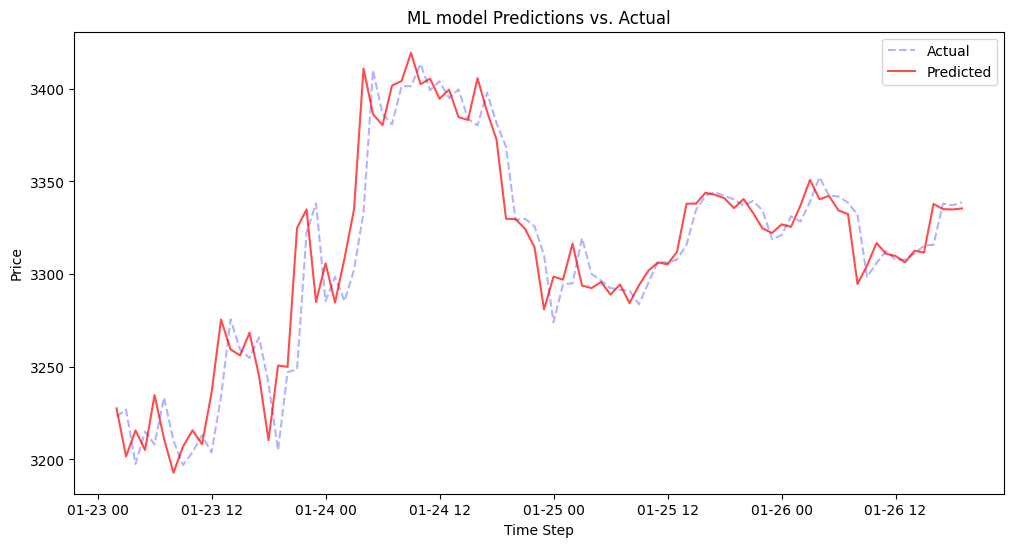

In [23]:
from utils.plots import plot

all_predictions = bt_best_params_test_data['MLPredictions']
all_targets = bt_best_params_test_data['Close']
plot(all_predictions[-90:], all_targets[-90:], "ML model Predictions vs. Actual")

In [24]:
class TechAnalysisWithMLFilterStrategy(Strategy):
    def init(self):
        self.signal = self.I(lambda: self.data.Signal)
        self.ml_prediction = self.I(lambda: self.data.MLPredictions)
        self.previous_signal = 0

    def next(self):
        current_signal = self.signal[-1]
        predicted_close_price = self.ml_prediction[-1]

        if current_signal == 1 and self.data.Close[-1] < predicted_close_price:
            self.position.close()
            self.buy()

        elif current_signal == -1 and self.data.Close[-1] > predicted_close_price:
            self.position.close()
            self.sell()

        self.previous_signal = current_signal

In [25]:
_ = run_backtest(bt_best_params_test_data, TechAnalysisWithMLFilterStrategy)

Start                     2024-01-26 20:00:00
End                       2025-01-26 19:00:00
Duration                    365 days 23:00:00
Exposure Time [%]                   79.974954
Equity Final [$]                1820582.13088
Equity Peak [$]                 2233472.04088
Return [%]                          82.058213
Buy & Hold Return [%]                47.82343
Return (Ann.) [%]                   81.464734
Volatility (Ann.) [%]              111.433657
Sharpe Ratio                          0.73106
Sortino Ratio                         2.35977
Calmar Ratio                         2.091413
Max. Drawdown [%]                  -38.952005
Avg. Drawdown [%]                   -3.144451
Max. Drawdown Duration      128 days 18:00:00
Avg. Drawdown Duration        4 days 12:00:00
# Trades                                   10
Win Rate [%]                             50.0
Best Trade [%]                      46.273118
Worst Trade [%]                    -13.808887
Avg. Trade [%]                    

In [26]:
df_best_regressors = pd.read_csv(COMMON_CONFIG.DATA_PATH + 'tsfresh_best_regressors.csv')
df_best_regressors

,index,MAE,RMSE,R2_score
0,ElasticNet,14.366080,21.994040,0.997916
1,Lasso,14.369626,21.998660,0.997915
2,BayesianRidge,14.369629,22.002205,0.997914
3,RANSACRegressor,14.421495,22.076280,0.997900
4,Ridge,14.464137,22.107482,0.997894


In [27]:
estimators = {}
for est_name, estimator in all_estimators():    
    estimators[est_name] = estimator

best_regressors = {}
for regressor in df_best_regressors['index']:
    best_regressors[regressor] = estimators[regressor]()

best_regressors

{'ElasticNet': ElasticNet(),
 'Lasso': Lasso(),
 'BayesianRidge': BayesianRidge(),
 'RANSACRegressor': RANSACRegressor(),
 'Ridge': Ridge()}

In [28]:
from sklearn.ensemble import VotingRegressor

voting_regressor = VotingRegressor(estimators=list(best_regressors.items()))
voting_regressor.fit(X_train_selected, y_train)

VotingRegressor(estimators=[('ElasticNet', ElasticNet()), ('Lasso', Lasso()),
                            ('BayesianRidge', BayesianRidge()),
                            ('RANSACRegressor', RANSACRegressor()),
                            ('Ridge', Ridge())])

In [29]:
predictions_df = pd.DataFrame(voting_regressor.predict(X_test_selected), index=X_test_selected.index, columns=['MLPredictions'])
predictions_df = predictions_df.shift(-1).dropna()
predictions_df

,MLPredictions
last_timestamp,
2024-01-26 20:00:00,2261.840604
2024-01-26 21:00:00,2270.325682
2024-01-26 22:00:00,2269.732549
2024-01-26 23:00:00,2282.746255
2024-01-27 00:00:00,2271.029671
...,...
2025-01-26 15:00:00,3312.316436
2025-01-26 16:00:00,3338.534339
2025-01-26 17:00:00,3335.729226


In [30]:
bt_best_params_test_data = pd.read_csv(COMMON_CONFIG.BT_BEST_PARAMS_TA_TEST_DATA_FILE)
bt_best_params_test_data.set_index('Datetime', inplace=True)
bt_best_params_test_data

,Open,High,Low,Close,Volume,Signal
Datetime,,,,,,
2024-01-26 20:00:00,2258.51,2262.69,2252.49,2258.60,11646.5910,0
2024-01-26 21:00:00,2258.60,2260.87,2253.00,2259.87,6455.0093,0
2024-01-26 22:00:00,2259.86,2272.00,2258.01,2268.01,6966.3637,0
2024-01-26 23:00:00,2268.01,2270.27,2263.99,2267.68,7176.1758,0
2024-01-27 00:00:00,2267.67,2280.31,2265.23,2280.18,12034.2632,0
...,...,...,...,...,...,...
2025-01-26 16:00:00,3315.31,3320.00,3307.96,3315.82,6878.4304,0
2025-01-26 17:00:00,3315.83,3344.88,3315.36,3338.04,9465.0436,0
2025-01-26 18:00:00,3338.03,3342.92,3334.02,3337.16,8731.0488,0


In [31]:
bt_best_params_test_data = pd.concat([bt_best_params_test_data.reset_index(), predictions_df.reset_index(drop=True)], axis=1)
bt_best_params_test_data["Datetime"] = pd.to_datetime(bt_best_params_test_data["Datetime"])
bt_best_params_test_data.set_index('Datetime', inplace=True)
bt_best_params_test_data = bt_best_params_test_data.dropna()
bt_best_params_test_data

,Open,High,Low,Close,Volume,Signal,MLPredictions
Datetime,,,,,,,
2024-01-26 20:00:00,2258.51,2262.69,2252.49,2258.60,11646.5910,0,2261.840604
2024-01-26 21:00:00,2258.60,2260.87,2253.00,2259.87,6455.0093,0,2270.325682
2024-01-26 22:00:00,2259.86,2272.00,2258.01,2268.01,6966.3637,0,2269.732549
2024-01-26 23:00:00,2268.01,2270.27,2263.99,2267.68,7176.1758,0,2282.746255
2024-01-27 00:00:00,2267.67,2280.31,2265.23,2280.18,12034.2632,0,2271.029671
...,...,...,...,...,...,...,...
2025-01-26 15:00:00,3311.09,3320.68,3308.74,3315.31,7303.5872,0,3312.316436
2025-01-26 16:00:00,3315.31,3320.00,3307.96,3315.82,6878.4304,0,3338.534339
2025-01-26 17:00:00,3315.83,3344.88,3315.36,3338.04,9465.0436,0,3335.729226


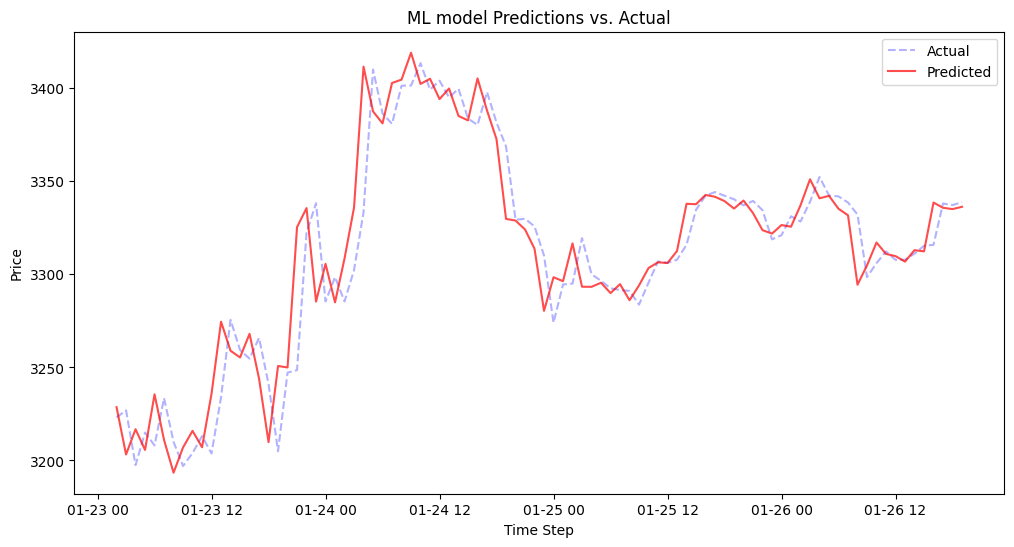

In [32]:
from utils.plots import plot

all_predictions = bt_best_params_test_data['MLPredictions']
all_targets = bt_best_params_test_data['Close']
plot(all_predictions[-90:], all_targets[-90:], "ML model Predictions vs. Actual")

In [33]:
_ = run_backtest(bt_best_params_test_data, TechAnalysisWithMLFilterStrategy)

Start                     2024-01-26 20:00:00
End                       2025-01-26 19:00:00
Duration                    365 days 23:00:00
Exposure Time [%]                   79.974954
Equity Final [$]                1820582.13088
Equity Peak [$]                 2233472.04088
Return [%]                          82.058213
Buy & Hold Return [%]                47.82343
Return (Ann.) [%]                   81.464734
Volatility (Ann.) [%]              111.433657
Sharpe Ratio                          0.73106
Sortino Ratio                         2.35977
Calmar Ratio                         2.091413
Max. Drawdown [%]                  -38.952005
Avg. Drawdown [%]                   -3.144451
Max. Drawdown Duration      128 days 18:00:00
Avg. Drawdown Duration        4 days 12:00:00
# Trades                                   10
Win Rate [%]                             50.0
Best Trade [%]                      46.273118
Worst Trade [%]                    -13.808887
Avg. Trade [%]                    